In [1]:
%matplotlib widget
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import PIL
from PIL import Image, ImageDraw

import purplerl.config as cfg
from purplerl.train_workbook import WorkbenchObsEncoder
from purplerl.workbook_env import WorkbookEnv
from purplerl.policy import StochasticPolicy, ContinuousPolicy, mlp

path = "/home/cthoens/code/UnityRL/purplerl"

/home/cthoens/anaconda3/envs/purplerl/lib/python3.10/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
cfg.use_cpu()
env = WorkbookEnv(sheet_path=f"{path}/sheets")
hidden_sizes=[64, 64]
fig = None
phase = "phase1"
run = "honest-wood-188"
#checkpoint = "lesson 1"
checkpoint = "checkpoint100"

policy= ContinuousPolicy(
    obs_encoder=WorkbenchObsEncoder(),
    hidden_sizes=hidden_sizes,
    action_space = env.action_space
)
value_net = nn.Sequential(
    policy.obs_encoder,
    mlp(list(policy.obs_encoder.shape) + hidden_sizes + [1])
)
checkpoint = torch.load(f"{path}/results/Workbook/{phase}/{run}/{checkpoint}.pt", map_location=cfg.device)
policy.load_checkpoint(checkpoint["policy"])
value_net.load_state_dict(checkpoint["policy_updater"]['value_net_state_dict'])

<All keys matched successfully>

In [3]:
def find_crop(img):
    for y in range(img.shape[0]):
        if np.any(img[y] > 0):
            upper = y
            break
    
    for y in range(img.shape[0]-1, upper, -1):
        if np.any(img[y] > 0):
            lower = y+1
            break
            
    img = img[upper:lower,:]
    
    for x in range(img.shape[1]):
        if np.any(img[:, x] > 0 ):
            left = x
            break
    
    for x in range(img.shape[1]-1, left+1, -1):
        if np.any(img[:, x] > 0 ):
            right = x+1
            break
            
    return np.array([[left, upper], [right, lower]])
        

In [31]:
lesson = 0
states = [[
    WorkbookEnv.SheetState(
        lesson = lesson,
        template_idx = template_idx,
        flip = False,
        rot=rot
    ) for rot in range(4)] for template_idx in range(max(len(env.templates[lesson]), 4))
]

env.set_lesson(lesson)

def evaluate(state):
    env.reset(sheet_state = state)

    spawn_points = env._get_spawn_points(env.sheet)
    
    values = np.zeros(spawn_points.shape)
    action_means = np.zeros(spawn_points.shape + env.action_space.shape)
    action_stddevs = np.zeros(spawn_points.shape + env.action_space.shape)
    
    for pt_idx, spawn_point in enumerate(spawn_points):
        idx = np.unravel_index(spawn_point, env.SHEET_OBS_SPACE.shape)[1:]
        env.steps_left = 1
        env.cursor_pos = idx
        obs = env._get_obs()
        obs = torch.as_tensor(obs.reshape((1,) + obs.shape))
        values[pt_idx] = value_net(obs) 
        actions_dists = policy.action_dist(obs)
        action_means[pt_idx] = actions_dists.mean.detach().numpy()
        action_stddevs[pt_idx] = actions_dists.stddev.detach().numpy()
        
    return env.sheet, spawn_points, values, action_means, action_stddevs

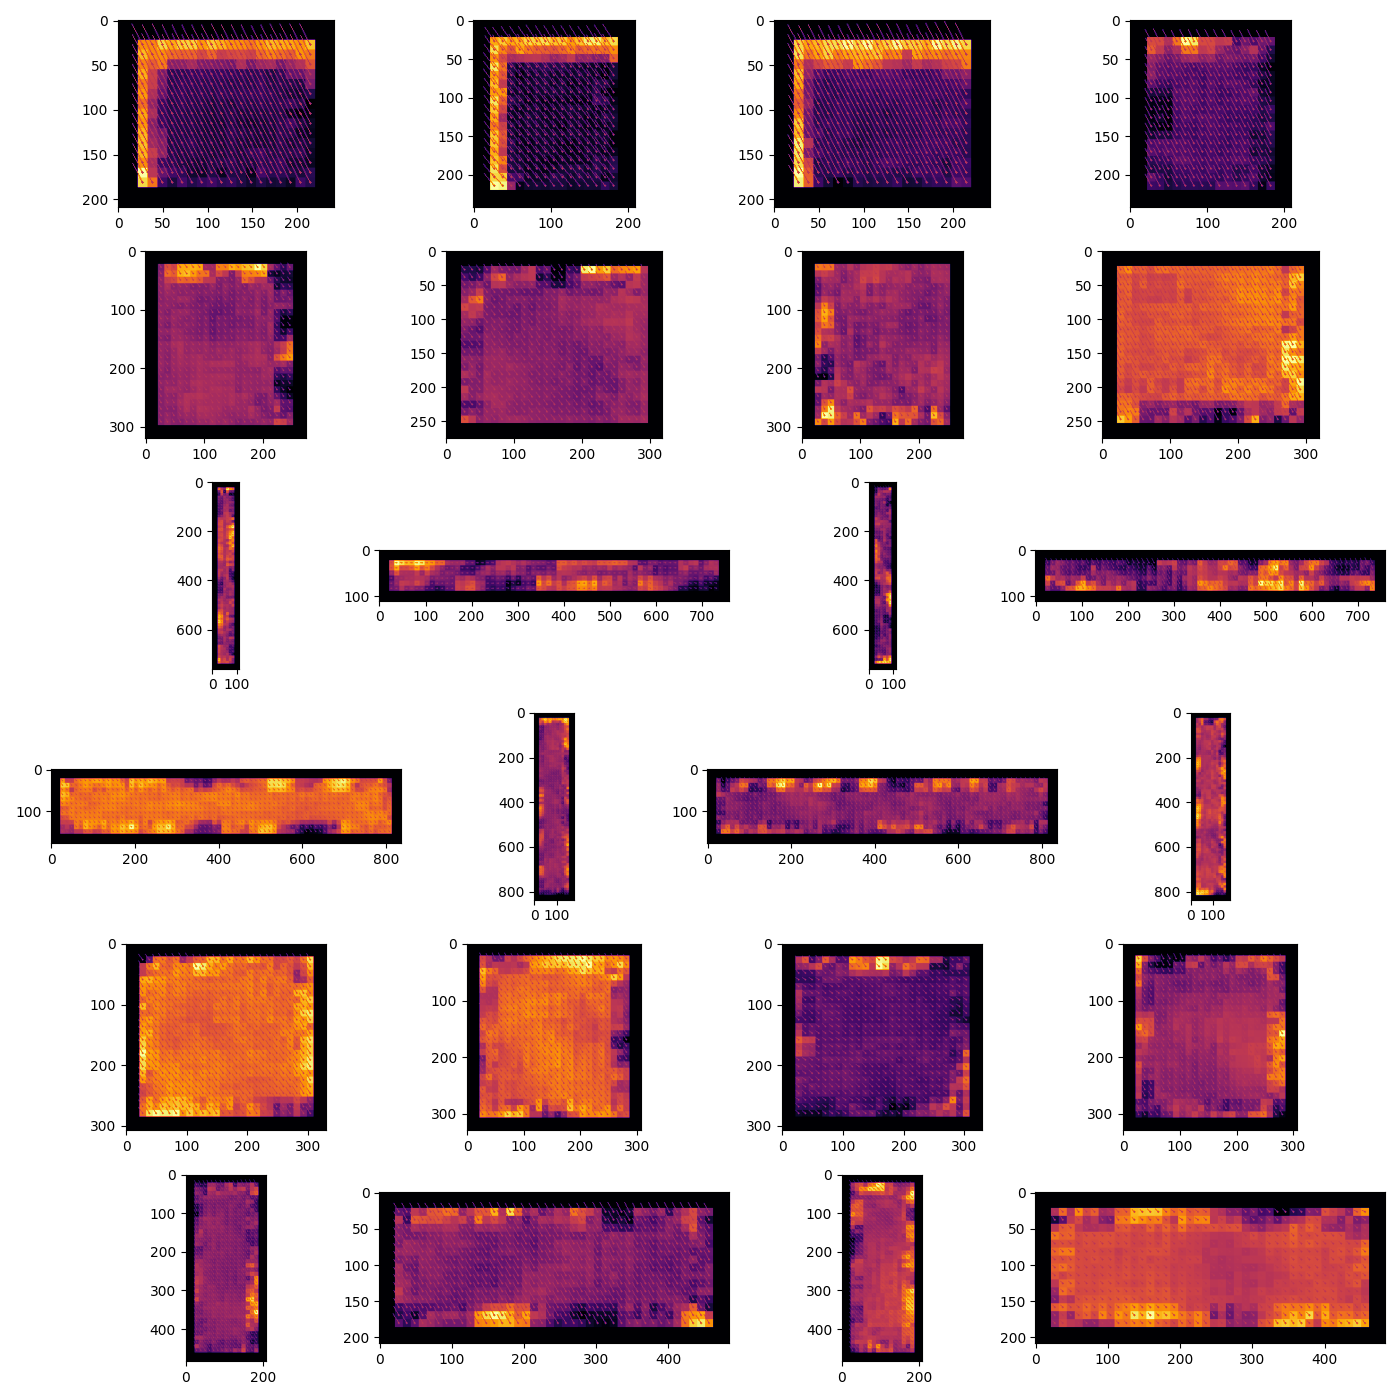

In [32]:
def visualize(sheet, spawn_points, values, action_means, action_stddevs, scale = 11):

    mid = scale // 2
    vmin = np.min(values)
    vmax = np.max(values)
    
    crop_rect = find_crop(env.sheet)
    crop_rect[0] -= int(env.max_speed)
    crop_rect[1] += int(env.max_speed)

    sheet = (np.array(sheet) + 1.0) / 2.0
    for pt_idx, spawn_point in enumerate(spawn_points):
        idx = np.unravel_index(spawn_point, env.SHEET_OBS_SPACE.shape)[1:]
        sheet[idx] = (values[pt_idx] - vmin) * 1.0 / (vmax - vmin)

    img = Image.fromarray(sheet)
    act_image = img.resize( (128 * scale, 128 * scale), resample = PIL.Image.NEAREST )

    draw = ImageDraw.Draw(act_image)
    for pt_idx, spawn_point in enumerate(spawn_points):
        idx = np.flip(np.array(np.unravel_index(spawn_point, env.SHEET_OBS_SPACE.shape)[1:]))

        direction = np.flip(action_means[pt_idx]) * scale
        center = idx*scale+mid
        draw.line([tuple(center), tuple(center+direction)], fill=0.5, width=1)
        draw.ellipse([tuple(center-1), tuple(center+1)], outline=0.5, width=1)
    
    crop = crop_rect * scale
    return act_image.crop(tuple(crop.flatten()))


plt.rcParams["figure.figsize"] = [14, 14]
plt.rcParams["figure.autolayout"] = True

fig, axs = plt.subplots(len(states), len(states[0]))
for plt_row, plt_state in zip(axs, states):
    for ax, state in zip(plt_row, plt_state):
        sheet, spawn_points, values, action_means, action_stddevs = evaluate(state)
        act_image_np = np.array(visualize(sheet, spawn_points, values, action_means, action_stddevs))        
        ax.imshow(act_image_np, cmap='inferno', vmin=0.0, vmax=1.0)